# Workshop CentraleSupélec - CeSIA

- Création : 02/2025 par [Nicolas Guillard](mailto:nicolas.guillar@securite-ia.fr) - bénévole au [CeSIA](https://www.securite-ia.fr/).

Créer en s'inspirant particulièrement de [Générer des noms de villes et communes françaises](https://github.com/alxndrTL/villes) par [Alexandre TL](https://www.youtube.com/@alexandretl)


## Présentation du sujet et Plan

## Indications de travail

Les éléments de ce TP :
- le présent carnet
- le répertoire `utils` et les fichiers contenus
- le fichier de données
- le répertoire weights contenant les poids des modèles

## Les modules et paramétrages globaux

Tous les modules nécessaires sont importés. A moins d'un besoin spécifique, il n'y aura pas besoin de modifier le bloc de code suivant.

In [1]:
# Modules prédéfinis et tiers
import math
import datetime
from dataclasses import dataclass
from collections import Counter
from typing import Tuple

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import trange, tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

In [40]:
#Modules créés pour le projet
from utils import CityNameDataset, SOS, EOS, PAD
from utils import print_colore, load_transformer_model, TransformerConfig, LanguageModel

### Device

Sélection du GPU selon l'environnement de travail

In [3]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


### Paramétrages

In [4]:
# Retirer la limite du nombre maximal de lignes affichées dans un tableau pandas
pd.set_option('display.max_rows', None) 

In [5]:
# Configurer le thème de seaborn
sns.set_theme(style="whitegrid")

In [6]:
# Paramétrer les graines aléatoires
pth_rnd_gen = torch.Generator(device).manual_seed(42)

## Interprétabilité

### Recherche des concepts avec l'utilisation d'un SAE

#### Définition d'un modèle de SAE

Présentation des concepts

##### EXERCICES

In [7]:
class AutoEncoder(nn.Module):
    def __init__(self, act_size: int, num_features: int, l1_coeff: float) -> None:
        super().__init__()

        self.l1_coeff = l1_coeff
        self.num_features = num_features

        self.W_enc = nn.Parameter(torch.nn.init.kaiming_uniform_(torch.empty(act_size, num_features)))
        self.b_enc = nn.Parameter(torch.zeros(num_features))

        self.W_dec = nn.Parameter(torch.nn.init.kaiming_uniform_(torch.empty(num_features, act_size)))
        self.b_dec = nn.Parameter(torch.zeros(act_size))

        self.W_dec.data[:] = self.W_dec / self.W_dec.norm(dim=-1, keepdim=True)
    
    def encode(self, x: torch.Tensor) -> torch.Tensor:
        x_cent = x - self.b_dec
        return F.relu(x_cent @ self.W_enc + self.b_enc) # calcul des activations des concepts
    
    def decode(self, x: torch.Tensor) -> torch.Tensor:
        return x @ self.W_dec + self.b_dec # calcul de la reconstruction

    def reconstruct_loss(self, x: torch.Tensor, acts: torch.Tensor, x_reconstruct: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        l2_loss = (x_reconstruct.float() - x.float()).pow(2).sum(-1).mean(0) # loss de reconstruction MSE
        l1_loss = self.l1_coeff * (acts.float().abs().sum()) # penalité L1 sur les activations des concepts
        return l1_loss, l2_loss
    
    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor] :
        """
        Args :
            x : input (B, S, act_size = d_model) ou (B*S, act_size = d_model)
        """
        hidden_acts = self.encode(x)
        x_reconstruct = self.decode(hidden_acts)

        l1_loss, l2_loss = self.reconstruct_loss(x, hidden_acts, x_reconstruct)
        loss = l2_loss + l1_loss # loss total

        return loss, x_reconstruct, hidden_acts, l2_loss, l1_loss
    
    # permet de stabiliser l'entraînement
    @torch.no_grad()
    def make_decoder_weights_and_grad_unit_norm(self):
        W_dec_normed = self.W_dec / self.W_dec.norm(dim=-1, keepdim=True)
        W_dec_grad_proj = (self.W_dec.grad * W_dec_normed).sum(-1, keepdim=True) * W_dec_normed
        self.W_dec.grad -= W_dec_grad_proj
        # Bugfix(?) for ensuring W_dec retains unit norm, this was not there when I trained my original autoencoders.
        self.W_dec.data = W_dec_normed

### Modification de la définition du Transformer

Il faut modifier la méthode de propagation afin de récupérer les activations de la couche cachée.

In [8]:
class LanguageModelForSAE(LanguageModel):
    def __init__(self, model_config: TransformerConfig) -> None:
        super().__init__(model_config)

    def forward(self, tokens: torch.Tensor, act: bool = False, stop_at_layer: int = None) -> torch.Tensor:
        """
        Args :
            tokens (torch.Tensor) : input shaped (B, s, vocab_size) with s in [1; S]
        """

        act = act or (stop_at_layer != None)

        x = self.embedding(tokens)
        x = self.core(x, stop_at_layer=stop_at_layer)

        if act:
            return x #(B, S, d_model)
        
        logits = self.get_logits_(x)

        return logits #(B, S, vocab_size)

 #### Entrainement d'un SAE

In [9]:
dataset = CityNameDataset(device=device)

creating vocabulary:   0%|          | 0/46 [00:00<?, ?it/s]

creatind dataset:   0%|          | 0/36585 [00:00<?, ?it/s]

In [10]:
d_model = 32 # dimension du modèle
n_heads = 4 # nombre de têtes pour l'attention
n_layers = 1 # nombre de couches
dropout = 0.

config = TransformerConfig(vocab_size=len(dataset.vocabulaire), d_model=d_model, n_heads=n_heads, n_layers=n_layers, dropout=dropout, max_len=dataset.max_len)

model = load_transformer_model(
    "./weights/model_32__4_heads__1_layers.pth", class_model=LanguageModelForSAE, config=config, device=device
    )

LanguageModelForSAE(
  (embedding): Embedding(46, 32, padding_idx=0)
  (core): Transformer(
    (PE): Embedding(47, 32)
    (in_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0): DecoderLayer(
        (attention_norm): RMSNorm()
        (sa): SelfAttentionMultiHead(
          (query_proj): Linear(in_features=32, out_features=32, bias=False)
          (key_proj): Linear(in_features=32, out_features=32, bias=False)
          (value_proj): Linear(in_features=32, out_features=32, bias=False)
          (c_proj): Linear(in_features=32, out_features=32, bias=False)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
        )
        (mlp_norm): RMSNorm()
        (mlp): MLP(
          (fc_1): Linear(in_features=32, out_features=128, bias=False)
          (fc_2): Linear(in_features=128, out_features=32, bias=False)
          (fc_3): Linear(in_features=32, out_features=128, bias=False)
          (dropout): Dropo

In [11]:
act_size = config.d_model
num_features = 4 * config.d_model
sae = AutoEncoder(act_size=act_size, num_features=num_features, l1_coeff=3e-4)
optim = torch.optim.Adam(sae.parameters(), lr=3e-4)

##### Exercice(s)

In [12]:
iterations = 1000
batch_size = 16
print_every = 100

sae.to(device)
sae.train()
for i in trange(iterations, desc="apprentissage"):
    # on récupère les données
    x, Y = dataset.get_batch(split='train', batch_size=batch_size) # (B, S)

    # on les fait passer dans le modèle et on récupère les activations du modèle (avec act=True, on "sort" du modèle avant la sortie)  
    hidden_acts_transfo = model(x, act=True).view(-1, config.d_model) # (B*S, d_model)

    loss, _, _, _, _ = sae(hidden_acts_transfo)
    loss.backward()
    sae.make_decoder_weights_and_grad_unit_norm()
    optim.step()
    optim.zero_grad()
    
    if i % print_every == 0:
        print(f"loss : {loss.item()}")
sae.eval();

apprentissage:   0%|          | 0/1000 [00:00<?, ?it/s]

loss : 6.52681827545166
loss : 2.305543899536133
loss : 1.5284489393234253
loss : 1.246800422668457
loss : 1.0492295026779175
loss : 0.9289937019348145
loss : 0.812456488609314
loss : 0.7798764705657959
loss : 0.7620857954025269
loss : 0.703209638595581


Explications concernant les fréquences des caractéristiques

In [13]:
# frequence d'activations des features sur un lot de données
x, Y = dataset.get_batch(split='val', batch_size=2048) # (B, S)
hidden_acts_transfo = model(x, act=True).view(-1, config.d_model)
_, _, features, _, _ = sae(hidden_acts_transfo) # (B*S, d_model)
features = features.to("cpu")

# activation : features > 0
rate = ((((features > 0).int()).sum(0) / features.shape[0]) < 1e-1).float().mean() * 100.
print(f"fraction des caractéristiques avec une fréquence d'activation < 1/10 : {rate:.3f}%")

rate = ((((features > 0).int()).sum(0) / features.shape[0]) < 1e-2).float().mean() * 100.
print(f"fraction des caractéristiques avec une fréquence d'activation < 1/100 : {rate:.3f}%")

rate = ((((features > 0).int()).sum(0) / features.shape[0]) < 1e-3).float().mean() * 100.
print(f"fraction des caractéristiques avec une fréquence d'activation < 1/1.000 : {rate:.3f}%")

#rate = ((((features > 0).int()).sum(0) / features.shape[0]) < 1e-4).float().mean()
#print(f"fraction des caractéristiques avec une fréquence d'activation < 1/10.000 : {rate:.3f}%")

fraction des caractéristiques avec une fréquence d'activation < 1/10 : 64.062%
fraction des caractéristiques avec une fréquence d'activation < 1/100 : 3.125%
fraction des caractéristiques avec une fréquence d'activation < 1/1.000 : 0.000%


Sauver les poids du SAE.

> Conseil : si vous souhaitez entrainer plusieurs fois le même SAE avec des hyperparamètres différentes, initialiser la variable `timestamp` ci-dessous à `True`. Cela provoquera l'ajout d'un marqueur temporel au format "YYYYMMDD-HHMMSS" dans le nom du fichier.

In [ ]:
timestamp = False
filename = f"./weights/sae_model_{d_model}__{n_heads}_heads__{n_layers}_layers"
if timestamp:
    filename += "__" + datetime.datetime.now().strftime("%Y%M%d-%I%M%S")
filename += ".pth"
torch.save(model.state_dict(), filename)

#### Visualisations

Explications

In [15]:
x, _ = dataset.get_batch(split='train', batch_size=1) # (B, S)
hidden_acts_transfo = model(x, act=True).view(-1, config.d_model) # (B*L, d_model)
_, act_recon, features, _, _ = sae(hidden_acts_transfo)

hidden_acts_transfo = hidden_acts_transfo.to("cpu").detach()
features = features.to("cpu").detach()
act_recon = act_recon.to("cpu").detach()

print("hidden_acts_transfo :", hidden_acts_transfo.size())
print("features :", features.size())
print("act_recon :", act_recon.size())

print("> nom :", dataset.to_string(x.to("cpu")[0].tolist()))

hidden_acts_transfo : torch.Size([46, 32])
features : torch.Size([46, 128])
act_recon : torch.Size([46, 32])
> nom : louroux-de-bouble


##### visualisation des activations cachées dans le Tranformer, pour un élément de séquence donné

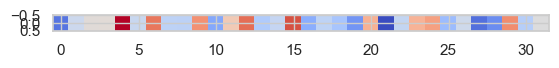

In [16]:
idx_elt_seq = 8
plt.imshow(hidden_acts_transfo[idx_elt_seq].view(1, -1), cmap="coolwarm")
#plt.axis('off')
plt.show()

##### visualisation des activations des caractéristiques pour toute la séquence

**Question :**
Sachant que dans l'image ci-dessous les abscisses représentent les indices des caractérisrtiques, et les ordonnées chaque élément de la séquence. Quelle interprétation à cette illustration ?

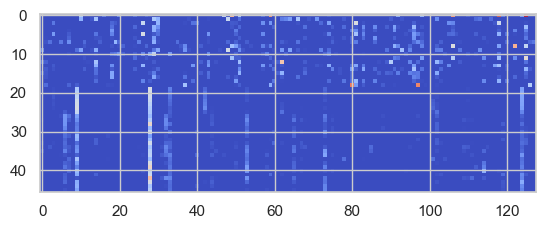

In [17]:
plt.imshow(features, cmap="coolwarm")
#plt.axis('off')
plt.show()

##### visualisation des activations des caractéristiques pour un élément de séquence donnée

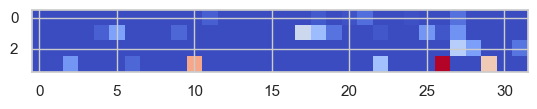

In [18]:
plt.imshow(features[idx_elt_seq].view(4, -1), cmap="coolwarm")
#plt.axis('off')
plt.show()

##### visualisation des activations successives d'une caractéristique dans le SAE

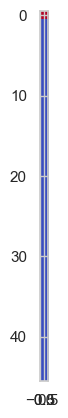

In [19]:
idx_feature = 16
plt.imshow(features[:, idx_feature].view(-1, 1), cmap="coolwarm")
#plt.axis('off')
plt.show()

##### visualisation des activations et de leurs reconstructions :

Visualisation des activations.

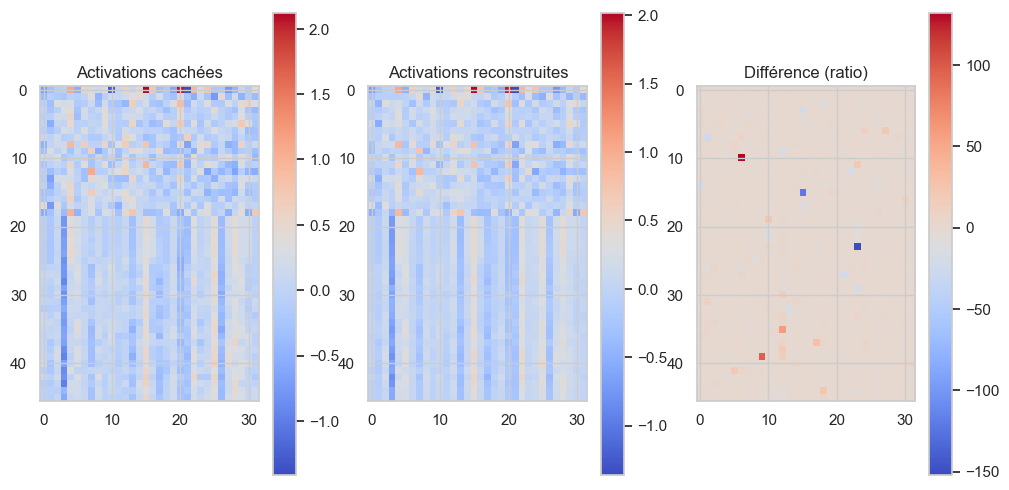

In [20]:
# Exemple de données pour les images
image1 = hidden_acts_transfo.numpy()
image2 = act_recon.numpy()

# Créer une figure avec deux sous-graphiques côte à côte
fig, axes = plt.subplots(1, 3, figsize=(12, 6))

# Afficher la première image
im1 = axes[0].imshow(image1, cmap="coolwarm")
axes[0].set_title('Activations cachées')
fig.colorbar(im1, ax=axes[0])

# Afficher la deuxième image
im2 = axes[1].imshow(image2, cmap="coolwarm")
axes[1].set_title('Activations reconstruites')
fig.colorbar(im2, ax=axes[1])

# Afficher la différence
diff = np.abs(image2 - image1) / image1
im3 = plt.imshow(diff, cmap="coolwarm")
axes[2].set_title('Différence (ratio)')
fig.colorbar(im3, ax=axes[2])

# Afficher la figure
plt.show()

Calcul de la perte en cas d'utilisation des reconstructions à la place des activations initiales.

In [23]:
x, Y = dataset.get_batch(batch_size=64) # (B, S)
hidden_acts_transfo = model(x, act=True).view(-1, config.d_model)
_, act_recon, features, _, _ = sae(hidden_acts_transfo)

logits = model.get_logits_(act_recon)

loss = F.cross_entropy(logits.view(-1, logits.size(-1)), Y.view(-1), ignore_index=dataset.char_to_int[PAD])
print(f"reconstruction loss : {loss.item():.2f}")

reconstruction loss : 2.17


#### Exploration des neurones et concepts

In [24]:
def load_sae(filename: str, act_size: int, num_features: int, device="cpu") -> torch.Tensor:
    sae = AutoEncoder(act_size=act_size, num_features=num_features, l1_coeff=3e-4)
    sae.load_state_dict(torch.load(filename))
    return sae.to(device)

In [25]:
do_load_sae = False
if do_load_sae:
    sea_weights = "./weights/model_32__4_heads__1_layers.pth"
    act_size = config.d_model
    num_features = 4 * config.d_model
    sae = load_sae(sea_weights, act_size=act_size, num_features=num_features, device=device)

##### neurones interprétables ?

On va essayer de découvrir quels caractéristiques ont été apprises par le modèle, en essayant d'interpréter les neurones d'une des (par défaut dans notre cas, de la...) couches cachées das le Transformer.

Le principe consiste à préserver les N valeurs d'activation (et les indices de l'entrée alors fournie au modèle) les plus grandes dans des tenseurs nommés `top_values` et `new_values`, grâce à la fonction `update_top_k()`.

Les appels successifs de cette fonction vont permettre de déterminer par paquets/batchs les valeurs d'activations (et leur indice) les plus grandes prises par les neurones cachées dans le Tranformer (cf l'utilisation en dessous).

In [26]:
def update_top_k(top_values, top_indices, new_values, new_indices, k=20):
    combined_values = torch.cat([top_values, new_values])
    combined_indices = torch.cat([top_indices, new_indices])
    
    new_top_values, topk_indices = torch.topk(combined_values, k)
    new_top_indices = combined_indices[topk_indices]
    
    return new_top_values, new_top_indices

Exemple d'utilisation de `update_top_k()` :

In [27]:
top_k = 20 # on garde les 20 exemples qui font s'activer le plus chaque neurone caché du Transformer
batch_size = 64 # on travaille par paquet de 64

On commence avec des valeurs minimales (`-inf`) et des indices arbitraires ($-1$).

- `top_values`, de taille (nb_neurones_cachés, top_k), répertorie les 20 valeurs d'activations max de chaque neurone,
- `top_indices`, de taille (nb_neurones_cachés, top_k), répertorie les indices qui correspondent à ces valeurs (indices=indice dans le dataset=indice d'une commune dans le jeu de données d'entrainement)
avec nb_neurones_cachés : nombre de neurones dans la couche du concernée du Trasformer, c'est à dire `d_model`.

Pour chaque paquet/batch :<br>
   - on fait passer le batch dans le réseau,<br>
   - on récupère les activations (B, S, nb_neurones_cachés) = nb_acts activations (une activation par neurone) pour chaque élément de séquence (S) pour chaque élément de batch, c.à.d un nom de commune (B),<br>
   - on prend en compte l'activation maximale (selon la position).<br>

Pour chaque neurone :<br>
   - on utilise la fonction `update_top_k` pour mettre à jour `top_values` et `top_indices`.


In [28]:
# Les plus petites valeurs possibles
top_values = torch.full((config.d_model, top_k), -float('inf'))
# indices à -1 (le dernier) du fait que les plus petites valeurs seront classées en dernier dans top_vales
top_indices = torch.full((config.d_model, top_k), -1, dtype=torch.long)

#Pour chaque élément du jeu de données d'entrainement
for i in trange(0, dataset.X_train.shape[0], batch_size):
    # par lot
    x = dataset.X_train[i:i+batch_size]
    # récupération des activations cachées du Transformer
    hidden_acts_transfo = model(x, act=True) # (B, L, d_model)
    # transfert vers le "cpu"
    hidden_acts_transfo = hidden_acts_transfo.to("cpu")
    # récupération la valeur maximale d'activation de chaque neurone cachée dans le Transformer, par batch
    max_act = hidden_acts_transfo.max(dim=1).values # (B, d_model)

    # pour chaque neurone caché du Transformer
    for id_neuron in range(config.d_model):
        # récupérer l'ensemble des valeurs d'activation de ce neurone
        dim_values = max_act[:, id_neuron]
        # calcul des indices pour chaque valeur d'activation (rappel: une par élément de batch)
        dim_indices = i + torch.arange(batch_size)

        # compilation des valeurs d'activations maximum selon l'indice du nom de commune dans le jeu de données d'entrainement
        top_values[id_neuron], top_indices[id_neuron] = update_top_k(top_values[id_neuron], top_indices[id_neuron], dim_values, dim_indices)

  0%|          | 0/515 [00:00<?, ?it/s]

In [29]:
max_activations, indices = top_values[:, 0].topk(k=20)
print("valeurs maximales : ", max_activations.tolist())
print("indices des neurones correspondants : ", indices.tolist())
max_activations_indices = top_indices[indices][0].tolist()
print("indices des noms de communes dans le jeu d'entrainement", max_activations_indices)


valeurs maximales :  [2.1229517459869385, 2.059461832046509, 1.692455768585205, 1.2143747806549072, 1.1729717254638672, 1.1559169292449951, 1.1125198602676392, 1.0922425985336304, 1.0658186674118042, 1.0178589820861816, 1.0141741037368774, 1.0049256086349487, 0.9398273229598999, 0.9214601516723633, 0.8959159255027771, 0.826645016670227, 0.8129128813743591, 0.8034628629684448, 0.7965403199195862, 0.7884460687637329]
indices des neurones correspondants :  [15, 20, 7, 4, 22, 13, 25, 12, 9, 6, 29, 27, 23, 31, 17, 24, 14, 0, 26, 10]
indices des noms de communes dans le jeu d'entrainement [22, 62, 61, 60, 59, 58, 57, 56, 55, 54, 53, 52, 51, 50, 49, 48, 47, 46, 45, 44]


Pour un neurone caché choisi via son indice dans [0; `d_model`], on affiche les `topK` noms de communes liés aux plus grandes valeurs d'activation détectées.

In [30]:
id_hidden_activation = 22
for i in top_indices[id_hidden_activation]:
    city_name = dataset.to_string(dataset.X_train[i.item()].tolist())
    hidden_acts_transfo = model(dataset.X_train[i.item()].unsqueeze(0), act=True) # (B, L, n_neurones)
    print_colore(city_name, hidden_acts_transfo[0, :, id_hidden_activation].tolist()[:len(city_name)])

Essayez avec différents neurones, en vous concentrant sur ceux ayant obtenu les plus grandes valeurs d'activation sur l'ensemble des neurones, de trouver des concepts explicites si cela est possible. Si oui, alors vous avez trouvé des neurones "monosémantique", sinon, vous constatetez leur caractère "polysémantique".

##### Concepts interprétables grâce au SAE ?

Le principe est exactement le même qu'avec les neurones, mais on regarde dans l'espace des activations du SAE.


In [31]:
top_k = 20 # on garde les 20 exemples qui font s'activer le plus chaque neurone caché du SAE
batch_size = 64 # on travaille par paquet de 64

In [32]:
# Les plus petites valeurs possibles
top_values_sae = torch.full((sae.num_features, top_k), -float('inf'))
# indices à -1 (le dernier) du fait que les plus petites valeurs seront classées en dernier dans top_vales
top_indices_sae = torch.full((sae.num_features, top_k), -1, dtype=torch.long)

#Pour chaque élément du jeu de données d'entrainement
for i in trange(0, dataset.X_train.shape[0], batch_size):
    # par lot
    x = dataset.X_train[i:i+batch_size]
    # récupération des activations cachées du Transformer
    hidden_acts_transfo = model(x, act=True) # (B, S, d_model)
    # récupération des activations de caractéristiques (features) correspondant
    _, _, features, _, _ = sae(hidden_acts_transfo)
    # récupération la valeur maximale d'activation de chaque caractéristique dans le SAE, par batch
    max_features = features.max(dim=1).values # (B, S, num_features)
    # transfert vers le "cpu"
    max_features = max_features.to("cpu")
    
     # pour chaque caractéristique gérée par le SAE
    for id_feature in range(sae.num_features):
        # récupérer l'ensemble des valeurs d'activation de cette caractéristique
        dim_values = max_features[:, id_feature]
        # calcul des indices pour chaque valeur d'activation (rappel: une par élément de batch)
        dim_indices = i + torch.arange(batch_size)

        # compilation des valeurs d'activations maximum selon l'indice du nom de commune dans le jeu de données d'entrainement
        top_values_sae[id_feature], top_indices_sae[id_feature] = update_top_k(top_values_sae[id_feature], top_indices_sae[id_feature], dim_values, dim_indices)

  0%|          | 0/515 [00:00<?, ?it/s]

In [33]:
max_activations_sae, indices_sae = top_values_sae[:, 0].topk(k=20)
print("valeurs maximales : ", max_activations_sae.tolist())
print("indices des caractéristiques correspondantes : ", indices_sae.tolist())
max_activations_indices_sae = top_indices_sae[indices][0].tolist()
print("indices des noms de communes dans le jeu d'entrainement", max_activations_indices_sae)

valeurs maximales :  [1.2650882005691528, 1.205565333366394, 1.1344462633132935, 1.1164509057998657, 1.105385184288025, 1.0002176761627197, 0.9028912782669067, 0.883921205997467, 0.8686330914497375, 0.8664737939834595, 0.8337341547012329, 0.8039000630378723, 0.7909359335899353, 0.7836132645606995, 0.7676773071289062, 0.7593322992324829, 0.7577836513519287, 0.7214229106903076, 0.6811668872833252, 0.672856330871582]
indices des caractéristiques correspondantes :  [122, 97, 28, 125, 80, 118, 9, 62, 106, 59, 29, 30, 10, 26, 66, 49, 14, 98, 114, 48]
indices des noms de communes dans le jeu d'entrainement [5197, 28365, 29912, 22187, 22557, 12154, 1919, 31959, 27534, 10742, 13503, 20548, 27605, 17990, 910, 11248, 20322, 22060, 19770, 31167]


In [37]:
idx_feature = 29
for i in top_indices_sae[idx_feature]:
    data_i = dataset.X_train[i.item()]
    city_name = dataset.to_string(data_i.tolist())
    ville = "".join([dataset.int_to_char[k] for k in [p.item() for p in dataset.X_train[i.item()] if p.item() != 0] if k != 1 and k != 2])
    hidden_acts_transfo = model(data_i.unsqueeze(0), act=True) # (B, S, n_features)
    _, _, features, _, _ = sae(hidden_acts_transfo)

    print_colore(city_name, features[0, :, idx_feature].tolist()[:len(city_name)])

### Modifier le comportement en le dirigeant

récupération des min et max des activations de chaque caractéristique dans le SAE.

In [ ]:
batch_size = 32 # on travaille par paquet de 64

model.eval();
sae.eval();

min_values_sae = torch.full((sae.num_features, 1), +float('inf'))
max_values_sae = torch.full((sae.num_features, 1), -float('inf'))

#Pour chaque élément du jeu de données d'entrainement
for i in trange(0, dataset.X_train.shape[0], batch_size):
    # par lot
    x = dataset.X_train[i:i+batch_size]
    # récupération des activations cachées du Transformer
    hidden_acts_transfo = model(x, act=True) # (B, S, d_model)
    # récupération des activations de caractéristiques (features) correspondant
    _, _, features, _, _ = sae(hidden_acts_transfo) # (B, S, n_features)
    
    features = features.to("cpu")

    min_features, _ = features.min(dim=0)
    min_features, _ = min_features.min(dim=0)
    min_values_sae = torch.min(min_values_sae, min_features)

    max_features, _ = features.max(dim=0)
    max_features, _ = max_features.max(dim=0)
    max_values_sae = torch.max(max_values_sae, max_features)

In [ ]:
print()

explications et descriptions

In [38]:
def steered_sample(model, sae, prompt = "", g = torch.Generator(), steering_vector=None, device="cpu"):
    """
    """
    idx = torch.tensor([dataset.char_to_int[c] for c in prompt], dtype=torch.int32, device=device).unsqueeze(0)
    idx = torch.cat([torch.tensor(dataset.char_to_int[SOS], device=device).view(1, 1), idx], dim=1)
    next_id = -1

    while next_id != dataset.char_to_int[EOS]:
        act = model(idx, act=True) # (1, l, d_model)

        # SAE
        features = sae.encode(act) # (1, l, num_features)
        act_reconstruct_1 = sae.decode(features) # (1, l, d_model) # reconstruction sans modification

        features[:, :, steering_vector[0].long()] = steering_vector[1].float() # forçage des concepts sur toutes les lettres
        act_reconstruct_2 = sae.decode(features) # reconstruction avec modification

        error = act - act_reconstruct_1
        final_act = act_reconstruct_2 + error

        x = model.out_norm(final_act)
        logits = model.lm_head(x)

        probs = F.softmax(logits[:, -1, :], dim=-1)
        next_id = torch.multinomial(probs, num_samples=1, generator=g).item()
        idx = torch.cat([idx, torch.tensor(next_id, device=device).view(1, 1)], dim=1)

        if idx.shape[1] > config.max_len:
            break
        
    return "".join([dataset.int_to_char[p.item()] for p in idx[0, 1:-1]])

In [43]:
steering_vector = torch.tensor([[29, 1]], dtype=int, device=device)

for i in range(15):
    print(steered_sample(model, sae, steering_vector=steering_vector.mT, prompt="", device=device, g=pth_rnd_gen))

sisaiiei-en-vieis
roimaiiejacouis
noise-saiiir-ege-en-meier
sainte-ozaine-eigaisesses-e
libiei-en-aigerieu-vaille
sèz-en
vei-seine-vaiie-baiieis-ieiiieieeiiieiaieiei
cous-eineine-viei-iegorie
seinsaiiiee
saint-ienvie
feilie-eneure
astiou-des-toigle-amaige
sainiee
ceaieix-susèemoni
seiérey-en-besieis-einier-s-e
